# Modelling fluid inclusion stretching during stalling
- This notebook shows how to model the stretching of CO2 dominated fluid inclusions in olivine using python tool pfiFI (DeVitre and Wieser, 2023; EarthArXiv), implemented in DiadFit. Note that this tool is not designed to model FI with fluids other than CO2 at this time, or those in phases other than olivine. It is based on the model of Wanamaker and Evans, 1989.
- In this example (DeVitre and Wieser, 2023; EarthArXiv), we model the stretching of a 2.5 micron radius CO2-dominated fluid inclusion, trapped at South Caldera Reservoir (Kilaeua volcano, Hawaii) that is stored at Hale'mau'mau reservoir for 2 years

## First, make sure CoolProp is installed if using the Span and Wagner 1996 equation of state
- You only need to run this once. If you do not wish to use CoolProp, or face installation problems, please use 'SP94' instead of 'SW96'

In [2]:
%pip install CoolProp

## Next import the necessary packages, including DiadFit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf

## Now let's model stretching and evaluate how density, pressure and radius change

### First, set the initial conditions

In [2]:
T_K = 1200 + 273.15  # Temperature in Kelvin (Here 1200 degrees Celsius converted to Kelvin)

R0 = 2.5 * 10**-6  # 

## Trapping reservoir conditions
Trapping_temp=1300
Trapping_pressure = 1 # in kbar

## surface conditions
Storage_temp=1150  # T in C
Storage_pressure = 0.001 # in kbar



b_m=100*10**-6 # distance to the crystal edge or crack (here 100 microns)
ascent_rate_ms=1 # ascent rate in m/s

depth_path_ini_fin_step=[10,0,20] #This defines the starting depth, ending depth and the number of steps in the path. More steps is better, especially for slow ascent rates.

crustal_model_config=pf.config_crustalmodel(crust_dens_kgm3=2750)# the configuration of your crustal model, here we set a single crustal density for the whole path; you can call help (pf.config_crustalmodel) for more options 

EOS='SW96' # Equation of state for CO2 (SW96 or SP94) if using SW96, ensure CoolProp is installed
plotfig=True # Whether to plot the figure or not
update_b=False # Whether to update b as the radius of the FI changes
report_results='fullpath' # Whether to report all the results, only the first and last step or only the last step

In [6]:
pf.convert_pressure_to_depth(P_kbar=0.4,crust_dens_kgm3=2750)

0    1.482717
dtype: float64

In [8]:
###### Let's model an FI (5 um) coming from South Caldera reservoir(4km @ 1300 C) and stalling at Halemaumau reservoir (1km @ 1150 C) ##############

####### Establish reservoir PTX conditions

## SC reservoir conditions
SC_depth = 4 # depth in km
melt_MgO=13 #melt MgO in wt%
SC_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ SC
model = 'ryan_lerner'
tolerance = 0.001
SC_pressure = pf.find_P_for_kmdepth(target_depth_km=SC_depth, crustal_model_config=pf.config_crustalmodel(model=model), tolerance=tolerance)

## HM reservoir conditions
HM_depth = 1 # depth in km
melt_MgO=6.5 #melt MgO in wt%
HM_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ HM
model = 'ryan_lerner'
tolerance = 0.001
HM_pressure = pf.find_P_for_kmdepth(target_depth_km=HM_depth, crustal_model_config=pf.config_crustalmodel(model=model), tolerance=tolerance)


In [ ]:
###### Let's model an FI (5 um) coming from South Caldera reservoir(4km @ 1300 C) and stalling at Halemaumau reservoir (1km @ 1150 C) ##############

####### Establish reservoir PTX conditions

## SC reservoir conditions
SC_depth = 4 # depth in km
melt_MgO=13 #melt MgO in wt%
SC_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ SC
model = 'ryan_lerner'
tolerance = 0.001
SC_pressure = pf.find_P_for_kmdepth(target_depth_km=SC_depth, crustal_model_config=pf.config_crustalmodel(model=model), tolerance=tolerance)

## HM reservoir conditions
HM_depth = 1 # depth in km
melt_MgO=6.5 #melt MgO in wt%
HM_temp=round(21.2*melt_MgO+1017,-1)  # T in C
# find pressure @ HM
model = 'ryan_lerner'
tolerance = 0.001
HM_pressure = pf.find_P_for_kmdepth(target_depth_km=HM_depth, crustal_model_config=pf.config_crustalmodel(model=model), tolerance=tolerance)


####### Let's start our model

### First let's calculate the CO2 density of our 5um FI trapped at SC
fi_rho_initial_gcm3=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=SC_pressure,T_K=SC_temp+273.15)[0]

## Now we move the FI to HM reservoir (1km), Pinternal will change bc T=1150, we calculate Pinternal
fi_Pi_HM_initial_MPa=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=fi_rho_initial_gcm3,T_K=HM_temp+273.15)['P_MPa'][0]

## Now let's leave two FI (1 um and 20 um) at HM for 2 years.

# set initial parameters 
years=2
days=years * 365.25

T = HM_temp + 273.15


R0 = 1 * 10 ** -6 # FI radius in m, here 1 micron
R0_2=20 * 10 ** -6 # FI radius in m, here 20 micron




def calc_multiplier(R0, dist2defect_um):
    multiplier = (dist2defect_um) / (R0 * 10**6)
    return multiplier

dist2defect_list=[50,100,250,500] # Let's estalish distance to crystal defects (here in microns)

b_list_R0=[calc_multiplier(R0, dist)*R0 for dist in dist2defect_list]
b_list_R0_2=[calc_multiplier(R0_2, dist)*R0_2 for dist in dist2defect_list]

b0=b_list_R0[0]
b1 = b_list_R0[1]
b2=b_list_R0[2]
b3=b_list_R0[3]

b4=b_list_R0[0]
b5 = b_list_R0[1]
b6=b_list_R0[2]
b7=b_list_R0[3]

Pinternal=fi_Pi_HM_initial_MPa
Pexternal=HM_pressure*100 ##Pressure in MPa for this model

steps=1000 #number of steps

EOS='SW96'
day_in_sec=(24*60*60)
totaltime_in_s=days*day_in_sec


def calculate_results(R_values, b_values, T, EOS, Pinternal, Pexternal, totaltime_in_s, steps, T4endcalc_PD):
    results_dict = {}

    for R in R_values:
        R_name = [name for name, value in globals().items() if value is R][0]
        R_key = f'{R_name}'
        results_dict[R_key] = {}

        for idx_b, b in enumerate(b_values):
            b_key = f'b{idx_b}'
            results = findR_Pi_rho_fixedPe_euler(R=R, b=b, T=T, EOS=EOS, Pinternal=Pinternal, Pexternal=Pexternal, totaltime=totaltime_in_s, steps=steps)
            
            results['Calculated depths (km)_HMT'] = pf.convert_pressure_to_depth(P_kbar=results['Pinternal(MPa)'] / 100, model='ryan_lerner')
            results['Calculated P from rho_SCTemp (MPa)'] = pf.calculate_P_for_rho_T(EOS='SW96', CO2_dens_gcm3=results['CO2_dens_gcm3'], T_K=T4endcalc_PD + 273.15)['P_MPa']
            results['Calculated depths (km)'] = pf.convert_pressure_to_depth(P_kbar=results['Calculated P from rho_SCTemp (MPa)'] / 100, model='ryan_lerner')
            
            results_dict[R_key][b_key] = results

    return results_dict


# Call the function with appropriate arguments
R_values = [R0, R0_2]  # Define R values
b_values = [b0, b1, b2, b3, b4, b5, b6, b7]

b_list= [b0, b1, b2, b3, b4, b5, b6, b7]

results_dict = calculate_results(R_values, b_values, T, EOS, Pinternal, Pexternal, totaltime_in_s, steps, SC_temp)


In [ ]:
#### PLOT RESULTS OF STRETCHING #####


seconds_in_e_year = 365.25 * 24 * 60 * 60


y_col='CO2_dens_gcm3'
x_col='Time(s)'
twin_col='Calculated depths (km)'

xlabel4plot='Time(years)'
ylabel4plot='CO2 density (g/cm3)'
twinlabel4plot='Calculated depth (km)'

linecolor='midnightblue'
linecolor2='purple'
linewidth=0.5


axes['E'].plot(results_dict['R0']['b0'][x_col]/seconds_in_e_year,results_dict['R0']['b0'][y_col],color=linecolor2,linestyle=':',linewidth=linewidth,label=str(round(b0*10**6)))
axes['E'].plot(results_dict['R0']['b1'][x_col]/seconds_in_e_year,results_dict['R0']['b1'][y_col],color=linecolor2,linestyle='-.',linewidth=linewidth,label=str(round(b1*10**6)))
axes['E'].plot(results_dict['R0']['b2'][x_col]/seconds_in_e_year,results_dict['R0']['b2'][y_col],color=linecolor2,linestyle='--', linewidth=linewidth,label=str(round(b2*10**6)))
axes['E'].plot(results_dict['R0']['b3'][x_col]/seconds_in_e_year,results_dict['R0']['b3'][y_col],color=linecolor2,linestyle='-',linewidth=linewidth, label=str(round(b3*10**6)))

axes['E'].plot(results_dict['R0_2']['b4'][x_col]/seconds_in_e_year,results_dict['R0_2']['b4'][y_col],color=linecolor,linestyle=':',linewidth=linewidth)
axes['E'].plot(results_dict['R0_2']['b5'][x_col]/seconds_in_e_year,results_dict['R0_2']['b5'][y_col],color=linecolor,linestyle='-.',linewidth=linewidth)
axes['E'].plot(results_dict['R0_2']['b6'][x_col]/seconds_in_e_year,results_dict['R0_2']['b6'][y_col],color=linecolor,linestyle='--', linewidth=linewidth)
axes['E'].plot(results_dict['R0_2']['b7'][x_col]/seconds_in_e_year,results_dict['R0_2']['b7'][y_col],color=linecolor,linestyle='-',linewidth=linewidth)


twinax_E=axes['E'].twinx()


ymin=np.nanmin([np.nanmin(results_dict['R0']['b0'][y_col]),np.nanmin(results_dict['R0_2']['b0'][y_col])])

ylim=[ymin,fi_rho_initial_gcm3]
xlim=([round(min(results_dict['R0']['b0'][x_col]/seconds_in_e_year)),round(max(results_dict['R0']['b0'][x_col]/seconds_in_e_year))])

ylim_P_E=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=pd.Series(ylim),T_K=SC_temp+273.15)['P_MPa']

ylim_D_E=pf.convert_pressure_to_depth(P_kbar=ylim_P_E/100,
                model='ryan_lerner')


axes['E'].set_xlim(xlim)
axes['E'].set_ylim(ylim)


def percent_drop(ylim, original_value):
    return 100-ylim*100/original_value

twinax_E.set_ylim(percent_drop(ylim_P_E,original_value=SC_pressure*100))

axes['E'].set_xlabel(xlabel4plot)

axes['E'].set_ylabel(ylabel4plot)

twinax_E.set_ylabel('Deviation from Entrapment Pressure (%)')

axes['E'].legend(title='Distance to defect (\u03BCm)')



### Now run the model
- Note that the decrease in density for the conditions of our model is very small (< 1%), in fact much smaller than the uncertainty in any measurement that could be made. 

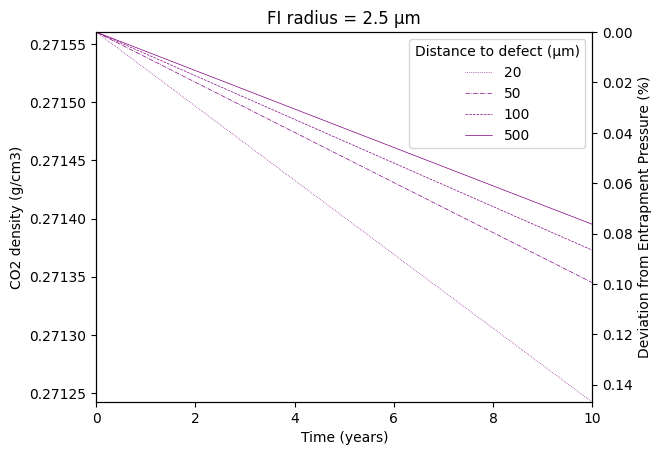

In [9]:
####### Establish reservoir and FI conditions

## FI radius
R0 = 2.5 * 10 ** -6 # radius of the FI in meters (here 2.5 microns)

## Trapping reservoir conditions
Trapping_temp=1300
Trapping_pressure = 1 # in kbar

## surface conditions
Storage_temp=1150  # T in C
Storage_pressure = 0.001 # in kbar

####### Let's start our model

### First let's calculate the CO2 density 
fi_rho_initial_gcm3=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=Trapping_pressure,T_K=Trapping_temp+273.15)[0]

## Now we move the FI to HM reservoir
fi_Pi_storage_initial_MPa=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=fi_rho_initial_gcm3,T_K=Storage_temp+273.15)['P_MPa'][0]

## Now let's leave it at HM for 10 days
days=10

## Choose equation of state, numerical method and distances to crytal defects

EOS='SW96' # Equation of state for CO2, option SW96, SP94 or ideal

method='RK1' # this is the numerical solver, options are RK1, RK2, RK3 and RK4 (Runge-Kutta)
steps=1000 #number of steps, more is better but slower

dist2defect_list=[20,50,100,500] # Distances to crystal defect structures in microns

T = Storage_temp + 273.15 # T in Kelvin for the model
Pinternal=fi_Pi_storage_initial_MPa
Pexternal=Storage_pressure*100 ##Pressure in MPa for this model

day_in_sec=(24*60*60)
totaltime=days*day_in_sec

## This calculates bvalues for the distances to defect you choose
def calc_multiplier(R0, dist2defect_um):
    multiplier = (dist2defect_um) / (R0 * 10**6)
    return multiplier

R_values = [R0]  # Define R values
b_values= [calc_multiplier(R0, dist)*R0 for dist in dist2defect_list]


# Call the function with appropriate arguments

results_dict_surface = pf.loop_R_b_constant_Pext(R_m_values=R_values, b_m_values=b_values, T_K=T, EOS=EOS, Pinternal_MPa=Pinternal, Pexternal_MPa=Pexternal, 
                                                    totaltime_s=totaltime, steps=steps, T4endcalc_PD=Trapping_temp,method=method,
                                              plotfig=False,crustal_model_config=crustal_model_config)


################## Now let's plot our results ######################

# Define some constants and variables
linecolor = 'darkred'
linecolor2 = 'orange'
seconds_in_e_year = 365.25 * 24 * 60 * 60
y_col = 'CO2_dens_gcm3'
x_col = 'Time(s)'
twin_col = 'Calculated depths (km)_TrappingT'
xlabel4plot = 'Time(years)'
ylabel4plot = 'CO2 density (g/cm3)'
twinlabel4plot = 'Calculated depth (km)_TrappingT'
linecolor = 'midnightblue'
linecolor2 = 'purple'
linewidth = 0.5

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data on the primary y-axis


ax.plot(results_dict_surface['R0']['b0'][x_col] / day_in_sec, results_dict_surface['R0']['b0'][y_col], color=linecolor2, linestyle=':', linewidth=linewidth, label=str(round(b_values[0] * 10 ** 6)))
ax.plot(results_dict_surface['R0']['b1'][x_col] / day_in_sec, results_dict_surface['R0']['b1'][y_col], color=linecolor2, linestyle='-.', linewidth=linewidth, label=str(round(b_values[1] * 10 ** 6)))
ax.plot(results_dict_surface['R0']['b2'][x_col] / day_in_sec, results_dict_surface['R0']['b2'][y_col], color=linecolor2, linestyle='--', linewidth=linewidth, label=str(round(b_values[2] * 10 ** 6)))
ax.plot(results_dict_surface['R0']['b3'][x_col] / day_in_sec, results_dict_surface['R0']['b3'][y_col], color=linecolor2, linestyle='-', linewidth=linewidth, label=str(round(b_values[3] * 10 ** 6)))
ax2 = ax.twinx()

xlim_F=([round(min(results_dict_surface['R0']['b0'][x_col]/day_in_sec)),round(max(results_dict_surface['R0']['b0'][x_col]/day_in_sec))])
ymin_F=np.nanmin([np.nanmin(results_dict_surface['R0']['b0'][y_col])])

ylim_F=[ymin_F,fi_rho_initial_gcm3]

ylim_P_F=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=pd.Series(ylim_F),T_K=Trapping_temp+273.15)['P_MPa']

ylim_D_F=pf.convert_pressure_to_depth(P_kbar=ylim_P_F/100,
                model='ryan_lerner')



def percent_drop(ylim, original_value):
    return 100-ylim*100/original_value



ax.set_xlim(xlim_F)
ax.set_ylim(ylim_F)
ax2.set_ylim(percent_drop(ylim_P_F,original_value=Trapping_pressure*100))

# Customize axis labels and legends
ax.set_title(f"FI radius = {round(R_values[0]*10**6,1)} μm")
ax.set_xlabel('Time (years)')
ax.set_ylabel(ylabel4plot)
ax2.set_ylabel('Deviation from Entrapment Pressure (%)')

ax.legend(title='Distance to defect (μm)')

